# PyOAE - Example calculation of the thermal and non-thermal components of pCO2

by Greg Pelletier, 23-Mar-2025

Variations in temperature can have a significant effect on pCO2 in seawater (Sarmiento and Gruber, 2006). Therefore, methods have been developed to normalize the observed pCO2 to mean values of temperature (e.g. Takahashi et al 2002; Fassbender et al 2022). 

**Takahashi's method of estimating non-thermal and thermal components of pCO2**

In order to remove the temperature effect from the observed pCO2, the non-thermal component of pCO2 (pCO2_NT) may be estimating by normalizing the observed pCO2 to the monthly anomaly of temperature of seawater at the observed location using the following equation from Takahashi et al (2002) with the PyOAE function "pco2_tnorm":

pCO2_NT = pCO2_obs * exp(0.0423 * (temp_mean - temp_obs))     (eqn 2)

where

- pCO2_obs = observed monthly pCO2 (uatm)
- temp_obs = observed monthly temperature co-inciding with observed pCO2_obs (degC)
- temp_mean = long-term average of temp_obs (degC)

The thermal component of pCO2 (pCO2_T) is estimated by Takahishi et al (2002) as follows

pCO2_T = pCO2_mean * exp(0.0423 * (temp_obs - temp_mean))     (eqn 3)

where

- pCO2_mean = long-term average of pCO2_obs (uatm)

The thermal component seasonal cycle anomaly (pCO2_Tanom) is estimated from the following equation (same as eqn 7 below):

pCO2_Tanom = pCO2_T - pCO2_mean     (eqn 4)

**Fassbender's method of estimating non-thermal and thermal components of pCO2**

As an alternative to Takahashi's method, PyOAE has the function "pco2_fass" to use the method described in Rodgers et al (2022) to apply Fassbender's method. The first step of Fassbender's method is to calculate the long-term average pCO2 (pCO2_AM) using a carbonate system calculator (e.g. PyCO2SYS) using inputs of the long-term averages of alkalinity (TA_mean), dissolved inorganic carbon (DIC_mean), total silicate (SIO4_mean), total phosphate (PO4_mean), temperature (temp_mean), and salinity (sal_mean), as follows:

pCO2_mean = f(temp_mean, sal_mean, TA_mean, DIC_mean, SIO4_mean, PO4_mean)   (eqn 5)

where "f" is the carbonate system calculation function (e.g. PyCO2SYS).

The thermally-driven component of pCO2 (pCO2_T) is calculated using the time-varying temperature observations (temp_obs), combined with the long-term averages of the other inputs to PyCO2SYS as follows:

pCO2_T = f(temp_obs, sal_mean, TA_mean, DIC_mean, SIO4_mean, PO4_mean)   (eqn 6)

The thermal pCO2 component seasonal cycle anomaly (pCO2_Tanom) is estimated from the following equation (same as eqn 4 above):

pCO2_Tanom = pCO2_T - pCO2_mean     (eqn 7)

Finally, the non-thermal component of pCO2 (pCO2_NT) is estimated with the following equation:

pCO2_NT = pCO2_obs - pCO2_Tanom     (eqn 8)

**Sine regression of pCO2_Tanom**

The repeating annual cycle of pCO2_Tanom can be represented as a sine function of the following form:

y = mean + amplitude * sin(2π * (x - phase) / period)	(eqn 2)

where 

- y = pCO2_Tanom
- x = time as decimal year fraction (1982-2022) 
- mean = mean from sine-regression
- amplitude = amplitude from sine-regression
- phase = phase shift from sine-regression
- period = assumed equal to 1 cycle per year

**OceanSODA-ETHZ and SeaFlux data used in this notebook**

In this example we use two netcdf files that we need to do the analysis, OceanSODA_ETHZ_for_PyOAE.nc and SeaFlux_for_PyOAE.nc, available to download at the following link:

https://drive.google.com/drive/folders/1BGgVRk2Gf6mxNnX1Fxg0Q4GtZSAYMzef?usp=sharing

**PyOAE functons pco2_tnorm, pco2_fass, and sine_fit**

PyOAE includes functions to calculate thermal and non-thermal components of pCO2 using Takahashi's method (function pco2_tnorm), and using Fassbender's method (function pco2_fass). 

**References**

- Takahasi et al 2002 (http://dx.doi.org/10.1016/S0967-0645(02)00003-6)
- Rodgers et al 2022 (https://doi.org/10.1029/2023GB007798)

**Install or upgrade PyOAE**

Run one of the next commands if needed to either install PyOAE for the first time, or upgrade PyOAE to the latest version

In [1]:
# # Run the following command to install PyOAE for the first time
# !pip install git+https://github.com/gjpelletier/PyOAE.git

# # Run the following command to upgrade PyOAE to the latest version
# !pip install git+https://github.com/gjpelletier/PyOAE.git --upgrade

**Import the packages that are needed and read the data that will be used in this example, and make a matlab-style timer to measure how long it takes to perform calculations**

In [20]:
from PyOAE import pco2_fass, pco2_tnorm, nnn, sine_fit
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing
import scipy.io

**Read OceanSODA-ETHZ data**

In [10]:
# read netcdf file of OceanSODA-ETHZ data
ds1 = xr.open_dataset("OceanSODA_ETHZ_for_PyOAE.nc",chunks={"x":60})
# Convert ds1 to dictionary of numpy arrays for computations
ds_dict = {var: ds1[var].values for var in ds1.data_vars}
# append yearfrac,lon,lat,time,pco2atm,fco2atm to ds_dict
ds_dict["yearfrac"] = ds1.yearfrac.values
ds_dict["x"] = ds1.x.values
ds_dict["y"] = ds1.y.values
ds_dict["time"] = ds1.time.values
# extract the dims
NT,NY,NX = ds_dict["talk"].shape

**Read SeaFlux data**

In [13]:
# read netcdf file of SeaFlux atmospheric pCO2
ds2 = xr.open_dataset("SeaFlux_for_PyOAE.nc",chunks={"x":60})
ds_dict["pco2atm"] = ds2.pco2atm.values
ds_dict["fco2atm"] = ds2.fco2atm.values

**Define a matlab-style tic toc timer to measure how long the computations take**

In [15]:
# matlab-style tic toc timer
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

# Fassbender's method of estimating pCO2_T, pCO2_NT, and pCO2_Tanom

**Transpose and combine x and y into 1d for multiprocessing**

In [14]:
# transpose and reshape arrays
ds_dict_T = {}
ds_dict_T["yearfrac"] = ds1.yearfrac.values
ds_dict_T["talk"] = np.transpose(ds_dict['talk'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["dic"] = np.transpose(ds_dict['dic'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["temperature"] = np.transpose(ds_dict['temperature'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["salinity"] = np.transpose(ds_dict['salinity'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["sio3"] = np.transpose(ds_dict['sio3'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["po4"] = np.transpose(ds_dict['po4'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["ph_total"] = np.transpose(ds_dict['ph_total'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["pco2atm"] = np.transpose(ds_dict['pco2atm'],(2,1,0)).reshape(NX*NY,NT)
ds_dict_T["fco2atm"] = np.transpose(ds_dict['fco2atm'],(2,1,0)).reshape(NX*NY,NT)
# initialize new output arrays
ds_dict_T["pco2_obs"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2_T_fass"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2_Tanom_fass"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2_NT_fass"] = np.full((NX*NY,NT), np.nan)
ds_dict_T["pco2_mean_fass"] = np.full((NX*NY), np.nan)

**Define the function that will calculate pCO2_T, pCO2_NT, and pCO2_Tanom during the multiprocessing loop**

In [18]:
# define the function to find the root in each grid cell i
def find_fass(i):
    kwargs = {
        'alkalinity': ds_dict_T["talk"][i,:],
        'dic': ds_dict_T["dic"][i,:],
        'total_silicate': ds_dict_T["sio3"][i,:],
        'total_phosphate': ds_dict_T["po4"][i,:],
        'temperature': ds_dict_T["temperature"][i,:],
        'salinity': ds_dict_T["salinity"][i,:],
        'total_pressure': 0,
        'opt_pH_scale': 1,  # pH scale (1= total scale)
        'opt_k_carbonic': 10,  # Choice of H2CO3 and HCO3- K1 and K2 (10= Lueker et al 2000)
        'opt_k_bisulfate': 1,  # Choice of HSO4- dissociation constant KSO4 (1= Dickson)
        'opt_total_borate': 1,  # Choice for boron:sal 
        'opt_k_fluoride': 1   # Choice for fluoride
        }
    # nnn = number of non-nan values for each input variable to dic_bio         
    nnn_talk = np.count_nonzero(~np.isnan(kwargs["alkalinity"]))  # number of non-nan
    nnn_dic = np.count_nonzero(~np.isnan(kwargs["dic"]))  # number of non-nan
    nnn_sio3 = np.count_nonzero(~np.isnan(kwargs["total_silicate"]))  # number of non-nan
    nnn_po4 = np.count_nonzero(~np.isnan(kwargs["total_phosphate"]))  # number of non-nan
    nnn_temp = np.count_nonzero(~np.isnan(kwargs["temperature"]))  # number of non-nan
    nnn_sal = np.count_nonzero(~np.isnan(kwargs["salinity"]))  # number of non-nan
    if (nnn_talk==nnn_dic and nnn_talk==nnn_sio3 and 
        nnn_talk==nnn_po4 and nnn_talk==nnn_temp and nnn_talk==nnn_sal and nnn_talk > 0):
        # solve for dic_bio = dic_obs - dic_atm
        result = pco2_fass(**kwargs)
        output = {
            'i': i,
            'result': result
            }
        return output

**The next step uses multiprocessiong and takes about half an hour to loop through all grid cells to calculate the thermal and non-thermal components of pCO2 using Fassbender's method**

In [24]:
# parallel processing loop through all grid cells
print('Computing pCO2_T, pCO2_NT, and pCO2_Tanom, please wait ...')
tic()
ncpu = 6   # number of CPU cores to use for parallel processing
with multiprocessing.Pool(processes=ncpu) as pool:    
    # Use imap_unordered to apply the function to a range of numbers
    results = pool.imap_unordered(find_fass, range(NX*NY))    
    # Iterate over the results as they become available
    for result in results:
        if result is not None:
            i = int(result['i'])
            ds_dict_T["pco2_obs"][i,:]= result['result']["pCO2_obs"]
            ds_dict_T["pco2_mean_fass"][i]= result['result']["pCO2_mean"]
            ds_dict_T["pco2_T_fass"][i,:]= result['result']["pCO2_T"]
            ds_dict_T["pco2_Tanom_fass"][i,:]= result['result']["pCO2_Tanom"]
            ds_dict_T["pco2_NT_fass"][i,:]= result['result']["pCO2_NT"]
            # print("i in loop: ",i) 
print('Done')
toc()

Computing pCO2_T, pCO2_NT, and pCO2_Tanom, please wait ...
Done
Elapsed time: 1747.849558 seconds.



**Reshape and transpose outputs back to original shape of inputs**

In [25]:
ds_dict["pco2_obs"] = np.reshape(ds_dict_T['pco2_obs'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2_T_fass"] = np.reshape(ds_dict_T['pco2_T_fass'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2_Tanom_fass"] = np.reshape(ds_dict_T['pco2_Tanom_fass'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2_NT_fass"] = np.reshape(ds_dict_T['pco2_NT_fass'],(NX,NY,NT)).transpose(2,1,0)
ds_dict["pco2_mean_fass"] = np.reshape(ds_dict_T['pco2_mean_fass'],(NX,NY)).transpose(1,0)

# Takahashi's method of estimating pCO2_T, pCO2_NT, and pCO2_Tanom

**The next step takes up to a few minutes to loop through all grid cells using Takahashi's method to calculate thermal and non-thermal components of pCO2**

In [26]:
# loop through all grid cells using Takahashi's method for thermal and non-thermal pCO2
print("Computing Takahashi's pco2_tnorm, please wait, this takes up to a few minutes ...")
# init tnorm
ds_dict["pco2_NT_tak"] = np.full_like(ds_dict["spco2"], np.nan)
ds_dict["pco2_T_tak"] = np.full_like(ds_dict["spco2"], np.nan)
ds_dict["pco2_Tanom_tak"] = np.full_like(ds_dict["spco2"], np.nan)
ds_dict["pco2_mean_tak"] = np.full_like(ds_dict["area"], np.nan)
for i in range(ds_dict["spco2"].shape[2]):
    # print("pco2_tnorm computed at lon %.1f degE" % (i+0.5))
    for j in range(ds_dict["spco2"].shape[1]):
        # nnn = number of non-nan values        
        nnn_pco2_obs = nnn(ds_dict["pco2_obs"][:,j,i])
        nnn_temp = nnn(ds_dict["temperature"][:,j,i])
        if (nnn_pco2_obs==nnn_temp and nnn_pco2_obs == np.size(ds_dict["pco2_obs"][:,j,i])):
            # solve for temperature-normalized pco2
            result_2 = pco2_tnorm(ds_dict['pco2_obs'][:,j,i], ds_dict['temperature'][:,j,i])
            ds_dict['pco2_NT_tak'][:,j,i] = result_2['pCO2_NT']
            ds_dict['pco2_T_tak'][:,j,i] = result_2['pCO2_T']
            ds_dict['pco2_Tanom_tak'][:,j,i] = result_2['pCO2_Tanom']
            ds_dict["pco2_mean_tak"][j,i] = result_2['pCO2_mean']
print("Done")

Computing Takahashi's pco2_tnorm, please wait, this takes up to a few minutes ...
Done


# Sine-regression of pCO2_Tanom during 1982-2022

In [27]:
# loop through all grid cells for sine_fit of Tanom (Fassbender)
print("Computing sine_fit of pCO2_Tanom (Fassbender), please wait, this takes up to a few minutes ...")
# init tnorm
ds_dict["pco2_Tanom_1982_2022_fass_fit"] = np.full_like(ds_dict['pco2_Tanom_fass'], np.nan)
ds_dict["pco2_Tanom_1982_2022_fass_mean"] = np.full_like(ds_dict["area"], np.nan)
ds_dict["pco2_Tanom_1982_2022_fass_amplitude"] = np.full_like(ds_dict["area"], np.nan)
ds_dict["pco2_Tanom_1982_2022_fass_phase"] = np.full_like(ds_dict["area"], np.nan)
ds_dict["pco2_Tanom_1982_2022_fass_rmse"] = np.full_like(ds_dict["area"], np.nan)
ds_dict["pco2_Tanom_1982_2022_fass_adj_rsquared"] = np.full_like(ds_dict["area"], np.nan)
ds_dict["pco2_Tanom_1982_2022_fass_pvalue"] = np.full_like(ds_dict["area"], np.nan)
for i in range(ds_dict["spco2"].shape[2]):
    # print("sine_fit computed at lon %.1f degE" % (i+0.5))
    for j in range(ds_dict["spco2"].shape[1]):
        # nnn = number of non-nan values        
        # nnn_pco2_obs = nnn(ds_dict["pco2_obs"][:,j,i])
        # nnn_pco2_bio_fass = nnn(ds_dict["pco2_bio_fass"][:,j,i])
        # if (nnn_pco2_obs==nnn_pco2_bio_fass and nnn_pco2_obs == np.size(ds_dict["pco2_obs"][:,j,i])):
        nnn_pco2_obs = nnn(ds_dict["pco2_obs"][:,j,i])
        nnn_pco2_Tanom_fass = nnn(ds_dict["pco2_Tanom_fass"][:,j,i])
        if (nnn_pco2_obs==nnn_pco2_Tanom_fass and nnn_pco2_obs == np.size(ds_dict["pco2_obs"][:,j,i])):
            # print('got one')
            # solve for dic_bio vs time sine-regression mean, amplitude, phase, rmse, y_fit
            result_1 = sine_fit(np.squeeze(ds_dict['yearfrac'])[:],ds_dict['pco2_Tanom_fass'][:,j,i])  
            ds_dict["pco2_Tanom_1982_2022_fass_fit"][:,j,i]= result_1["y_fit"]
            ds_dict["pco2_Tanom_1982_2022_fass_mean"][j,i]= result_1["mean"]
            ds_dict["pco2_Tanom_1982_2022_fass_amplitude"][j,i]= result_1["amplitude"]
            ds_dict["pco2_Tanom_1982_2022_fass_phase"][j,i]= result_1["phase"]
            ds_dict["pco2_Tanom_1982_2022_fass_rmse"][j,i]= result_1["rmse"]
            ds_dict["pco2_Tanom_1982_2022_fass_adj_rsquared"][j,i]= result_1["adj_rsquared"]
            ds_dict["pco2_Tanom_1982_2022_fass_pvalue"][j,i]= result_1["pvalue"]
print("Done")

Computing sine_fit of pCO2_Tanom (Fassbender), please wait, this takes up to a few minutes ...
Done


# Results of the sine-regressions for pCO2_Tanom

**Maps of the mean, amplitude, RMSE, r-squared, and p-values of pCO2_Tanom**

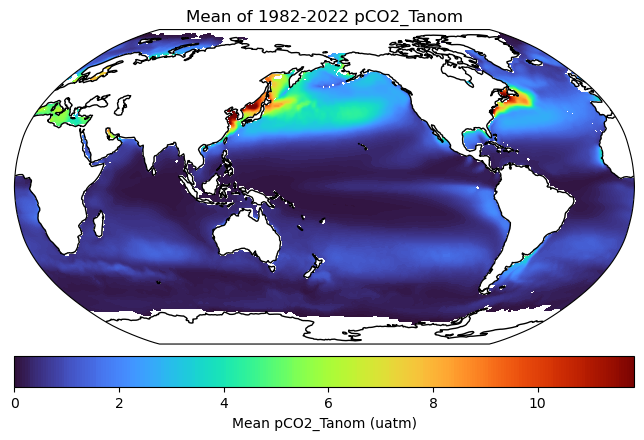

In [28]:
# Robinson map of the sine-regression mean values of pCO2_Tanom
import cartopy.crs as ccrs
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = ds_dict["pco2_Tanom_1982_2022_fass_mean"].copy()
# cosmetic trim of the extreme tails of Z for better color contrast in the map plot
zmin = np.nanpercentile(Z,0.1)
zmax = np.nanpercentile(Z,99.9)
Z[Z<zmin]=zmin
Z[Z>zmax]=zmax
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'Mean of 1982-2022 pCO2_Tanom')
# plt.contourf(X,Y,Z,cmap='plasma',levels=256,vmin=zmin,vmax=zmax,transform=ccrs.PlateCarree());
plt.contourf(X,Y,Z,cmap='turbo',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label='Mean pCO2_Tanom (uatm)',ticks=[0,2,4,6,8,10,12,14,16,18]);
plt.savefig('Fig10_map_of_pCO2_Tanom_1982_2022_fass_mean_robinson_v2.png', format='png', dpi=300)
plt.show()

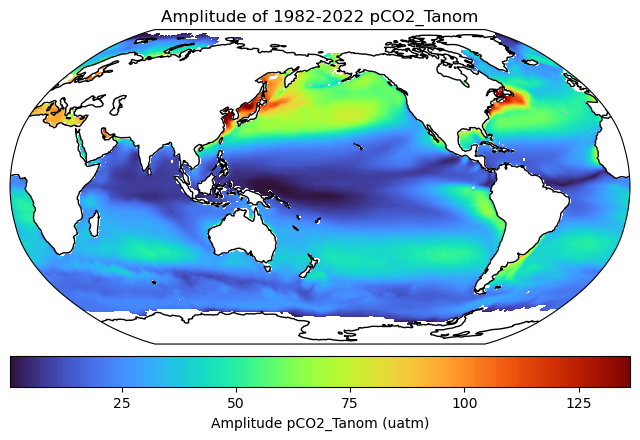

In [29]:
# Robinson map of the sine-regression amplitude values of pCO2_Tanom
import cartopy.crs as ccrs
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = np.abs(ds_dict["pco2_Tanom_1982_2022_fass_amplitude"]).copy()
# cosmetic trim of the extreme tails of Z for better color contrast in the map plot
zmin = np.nanpercentile(Z,0.1)
zmax = np.nanpercentile(Z,99.9)
Z[Z<zmin]=zmin
Z[Z>zmax]=zmax
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'Amplitude of 1982-2022 pCO2_Tanom')
# plt.contourf(X,Y,Z,cmap='plasma',levels=256,vmin=zmin,vmax=zmax,transform=ccrs.PlateCarree());
plt.contourf(X,Y,Z,cmap='turbo',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label='Amplitude pCO2_Tanom (uatm)',ticks=[0,25,50,75,100,125,150,175,200]);
plt.savefig('Fig11_map_of_pCO2_Tanom_1982_2022_fass_amplitude_robinson_v2.png', format='png', dpi=300)
plt.show()

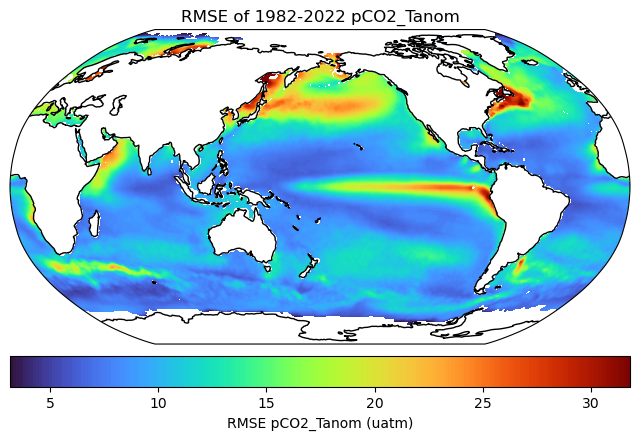

In [30]:
# Robinson map of the sine-regression RMSE values of pCO2_Tanom
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = np.abs(ds_dict["pco2_Tanom_1982_2022_fass_rmse"]).copy()
# cosmetic trim of the extreme tails of Z for better color contrast in the map plot
zmin = np.nanpercentile(Z,0.1)
zmax = np.nanpercentile(Z,99.9)
Z[Z<zmin]=zmin
Z[Z>zmax]=zmax
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'RMSE of 1982-2022 pCO2_Tanom')
# plt.contourf(X,Y,Z,cmap='turbo',levels=256,vmin=zmin,vmax=zmax,transform=ccrs.PlateCarree());
plt.contourf(X,Y,Z,cmap='turbo',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label='RMSE pCO2_Tanom (uatm)',ticks=[5,10,15,20,25,30,35,40,45,50]);
plt.savefig('Fig12_map_of_pCO2_Tanom_1982_2022_fass_rmse_robinson_v2.png', format='png', dpi=300)
plt.show()

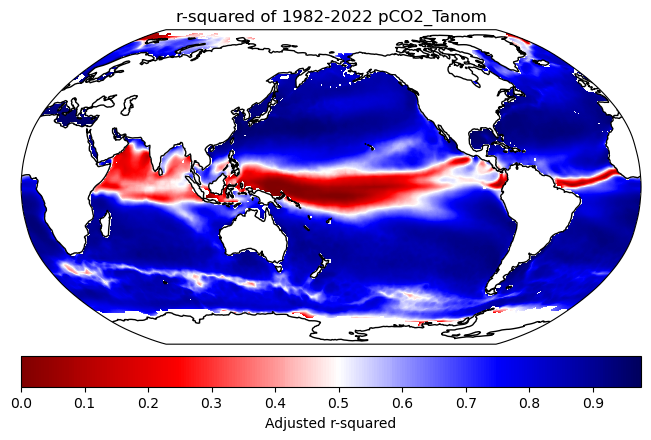

In [31]:
# Robinson map of the sine-regression rsquared values of pCO2_Tanom
from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = np.abs(ds_dict['pco2_Tanom_1982_2022_fass_adj_rsquared'])
# Define the zero point
vmin = 0
vmax = 1.0
vcenter = 0.5
# Create a normalization instance
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'r-squared of 1982-2022 pCO2_Tanom')
plt.contourf(X,Y,Z,cmap='seismic_r',transform=ccrs.PlateCarree(), norm=norm,levels=256);
# plt.contourf(X,Y,Z,cmap='plasma',levels=256,transform=ccrs.PlateCarree());
plt.colorbar(orientation="horizontal", pad=0.03,label='Adjusted r-squared',ticks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]);
plt.savefig('Fig13_map_of_pCO2_Tanom_1982_2022_fass_rsquared_robinson_v2.png', format='png', dpi=300)
plt.show()

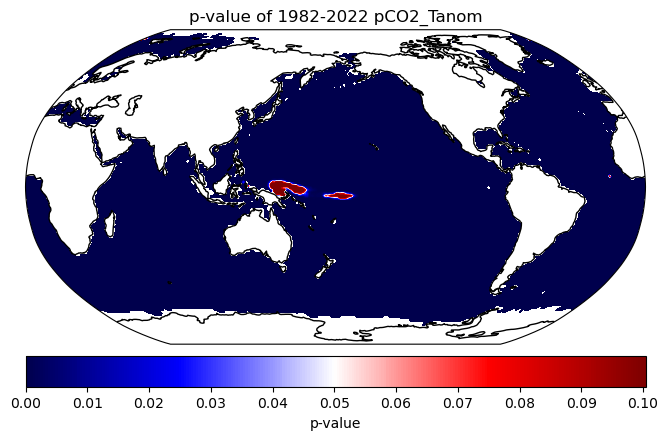

In [32]:
# Robinson map of the sine-regression rsquared values of pCO2_Tanom
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import LinearLocator
plt.figure(figsize=(8, 5))
X = ds_dict['x']
Y = ds_dict['y']
Z = np.abs(ds_dict['pco2_Tanom_1982_2022_fass_pvalue'])
Z[Z>0.1]=0.1
# Define the zero point
vmin = 0
vmax = 0.1
vcenter = 0.05
# Create a normalization instance
norm = TwoSlopeNorm(vmin=vmin,vcenter=vcenter,vmax=vmax)
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
ax.coastlines()
# ax.gridlines()
plt.title(r'p-value of 1982-2022 pCO2_Tanom')
plt.contourf(X,Y,Z,cmap='seismic',transform=ccrs.PlateCarree(),norm=norm,levels=256);
cbar = plt.colorbar(orientation="horizontal", pad=0.03,label='p-value',ticks=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 
                                                                              0.06, 0.07, 0.08, 0.09, 0.1]);
# Set the number of ticks using LinearLocator
# cbar.locator = LinearLocator(numticks=9)
# cbar.update_ticks()
plt.savefig('Fig14_map_of_pCO2_Tanom_1982_2022_fass_pvalue_robinson_v2.png', format='png', dpi=300)
plt.show()

# Time series at three locations in the coastal California Current Ecosystem:

- Columbia River
- San Francisco
- Huntington

Panel a shows the time-series of pCO2_NT, pCO2_T, and pCO2_Tanom. The pCO2_NT, pCO2_T, and pCO2_Tanom values are very simular using Takahashi's and Fassbender's method. Panel c shows that the annually recurring seasonal cycle of pCO2_Tanom is well represented by the sine-regression fit near the Columbia River and Huntington, and less well near San Francisco.

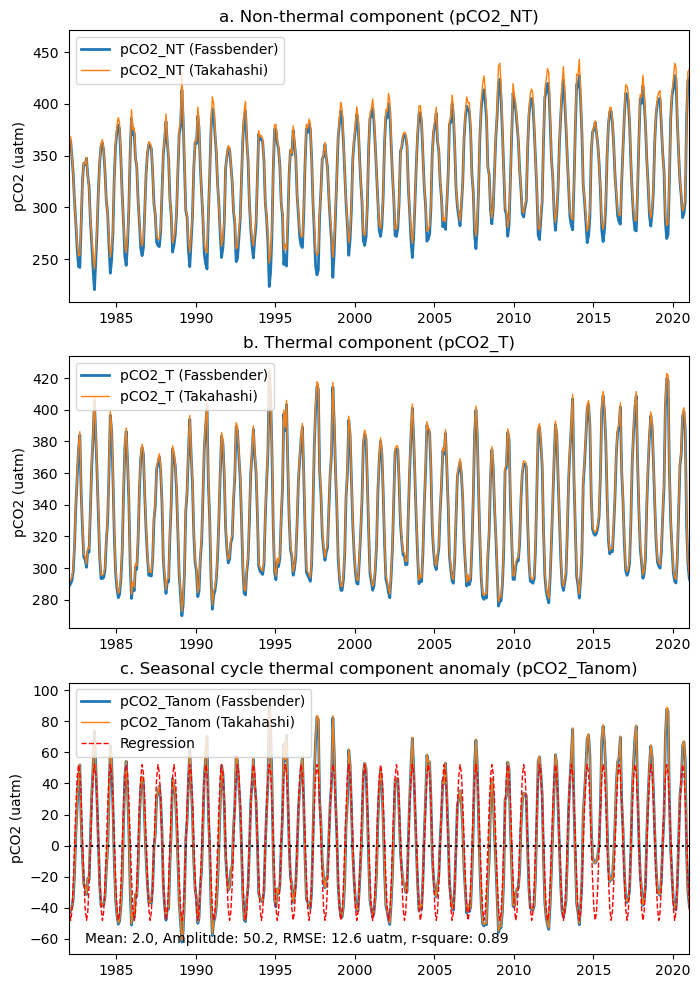

In [33]:
# Columbia River location i,j coordinates
i=234
j=136
fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 12)
)
# - - -
# Plot at ['A']
ax['A'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_NT_fass"][:,j,i]), label='pCO2_NT (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['A'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_NT_tak"][:,j,i]), label='pCO2_NT (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['A'].set_ylabel('pCO2 (uatm)')
ax['A'].legend(loc='upper left')
ax['A'].set_title('a. Non-thermal component (pCO2_NT)')
# ax['A'].set_xlim(2014, 2019)
ax['A'].set_xlim(1982, 2021)
# - - -
# Plot at ['B']
ax['B'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_T_fass"][:,j,i]), label='pCO2_T (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['B'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_T_tak"][:,j,i]), label='pCO2_T (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['B'].set_ylabel('pCO2 (uatm)')
ax['B'].legend(loc='upper left')
ax['B'].set_title('b. Thermal component (pCO2_T)')
# ax['B'].set_xlim(2014, 2019)
ax['B'].set_xlim(1982, 2021)
# - - -
# Plot at ['B']
ax['C'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_Tanom_fass"][:,j,i]), label='pCO2_Tanom (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['C'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_Tanom_tak"][:,j,i]), label='pCO2_Tanom (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['C'].plot(np.squeeze(ds_dict['yearfrac']), np.squeeze(ds_dict["pco2_Tanom_1982_2022_fass_fit"][:,j,i]), label='Regression', color="red", linestyle='--', marker='', linewidth=1)
ax['C'].set_ylabel('pCO2 (uatm)')
ax['C'].legend(loc='upper left')
ax['C'].set_title('c. Seasonal cycle thermal component anomaly (pCO2_Tanom)')
# ax['C'].set_xlim(2014, 2019)
ax['C'].set_xlim(1982, 2021)
str_mean = f"{ds_dict["pco2_Tanom_1982_2022_fass_mean"][j,i]:.1f}"
str_amp = f"{ds_dict["pco2_Tanom_1982_2022_fass_amplitude"][j,i]:.1f}"
str_rmse = f"{ds_dict["pco2_Tanom_1982_2022_fass_rmse"][j,i]:.1f}"
str_rsq = f"{ds_dict["pco2_Tanom_1982_2022_fass_adj_rsquared"][j,i]:.2f}"
ax['C'].text(1983, -60, 'Mean: '+str_mean+', Amplitude: '+str_amp+', RMSE: '+str_rmse+' uatm'+', r-square: '+str_rsq,
        fontsize=10, color='black', ha='left', va='center')
# ax['B'].text(1983, -60, 'Mean: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_mean"][j,i]:.1f}"+', Amplitude: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_amplitude"][j,i]:.1f}"+', RMSE: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_rmse"][j,i]:.1f}"+' uatm',
#         fontsize=10, color='black', ha='left', va='center')
ax['C'].axhline(y=0, color='k', linestyle=':')
ax['C'].set_ylim(-70, 105)
# ax['C'].set_ylim(-140, 90)
# - - -
fig.savefig('Fig15_pco2_NT_T_Tanom_at_ColumbiaRiver_1982-2020_v2.png', format='png', dpi=300);

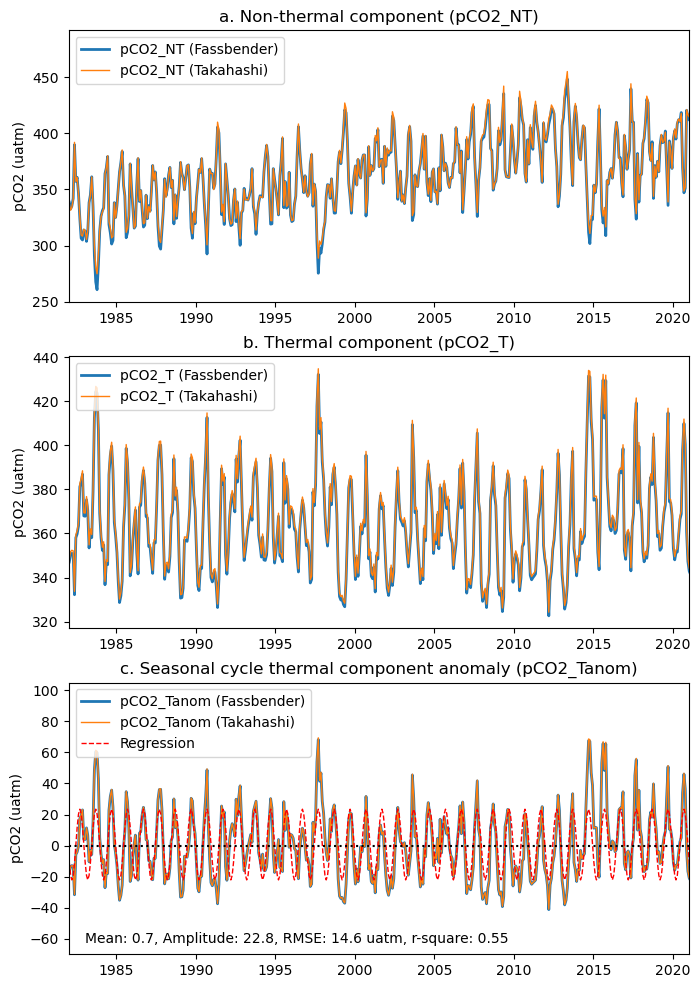

In [34]:
# San Francisco location i,j coordinates
i=236
j=127
fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 12)
)
# - - -
# Plot at ['A']
ax['A'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_NT_fass"][:,j,i]), label='pCO2_NT (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['A'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_NT_tak"][:,j,i]), label='pCO2_NT (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['A'].set_ylabel('pCO2 (uatm)')
ax['A'].legend(loc='upper left')
ax['A'].set_title('a. Non-thermal component (pCO2_NT)')
# ax['A'].set_xlim(2014, 2019)
ax['A'].set_xlim(1982, 2021)
# - - -
# Plot at ['B']
ax['B'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_T_fass"][:,j,i]), label='pCO2_T (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['B'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_T_tak"][:,j,i]), label='pCO2_T (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['B'].set_ylabel('pCO2 (uatm)')
ax['B'].legend(loc='upper left')
ax['B'].set_title('b. Thermal component (pCO2_T)')
# ax['B'].set_xlim(2014, 2019)
ax['B'].set_xlim(1982, 2021)
# - - -
# Plot at ['B']
ax['C'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_Tanom_fass"][:,j,i]), label='pCO2_Tanom (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['C'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_Tanom_tak"][:,j,i]), label='pCO2_Tanom (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['C'].plot(np.squeeze(ds_dict['yearfrac']), np.squeeze(ds_dict["pco2_Tanom_1982_2022_fass_fit"][:,j,i]), label='Regression', color="red", linestyle='--', marker='', linewidth=1)
ax['C'].set_ylabel('pCO2 (uatm)')
ax['C'].legend(loc='upper left')
ax['C'].set_title('c. Seasonal cycle thermal component anomaly (pCO2_Tanom)')
# ax['C'].set_xlim(2014, 2019)
ax['C'].set_xlim(1982, 2021)
str_mean = f"{ds_dict["pco2_Tanom_1982_2022_fass_mean"][j,i]:.1f}"
str_amp = f"{ds_dict["pco2_Tanom_1982_2022_fass_amplitude"][j,i]:.1f}"
str_rmse = f"{ds_dict["pco2_Tanom_1982_2022_fass_rmse"][j,i]:.1f}"
str_rsq = f"{ds_dict["pco2_Tanom_1982_2022_fass_adj_rsquared"][j,i]:.2f}"
ax['C'].text(1983, -60, 'Mean: '+str_mean+', Amplitude: '+str_amp+', RMSE: '+str_rmse+' uatm'+', r-square: '+str_rsq,
        fontsize=10, color='black', ha='left', va='center')
# ax['B'].text(1983, -60, 'Mean: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_mean"][j,i]:.1f}"+', Amplitude: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_amplitude"][j,i]:.1f}"+', RMSE: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_rmse"][j,i]:.1f}"+' uatm',
#         fontsize=10, color='black', ha='left', va='center')
ax['C'].axhline(y=0, color='k', linestyle=':')
ax['C'].set_ylim(-70, 105)
# - - -
fig.savefig('Fig15_pco2_NT_T_Tanom_at_SanFrancisco_1982-2020_v2.png', format='png', dpi=300);

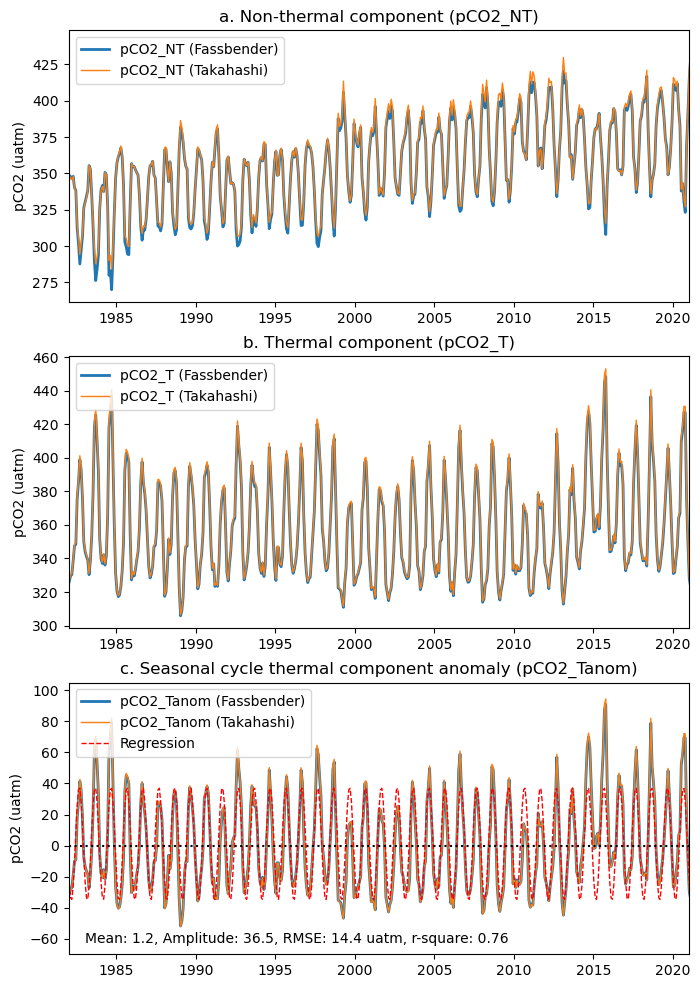

In [35]:
# Huntington location i,j coordinates
i=241
j=122
fig, ax = plt.subplot_mosaic(
    '''
    A
    B
    C
    ''',
    figsize = (8, 12)
)
# - - -
# Plot at ['A']
ax['A'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_NT_fass"][:,j,i]), label='pCO2_NT (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['A'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_NT_tak"][:,j,i]), label='pCO2_NT (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['A'].set_ylabel('pCO2 (uatm)')
ax['A'].legend(loc='upper left')
ax['A'].set_title('a. Non-thermal component (pCO2_NT)')
# ax['A'].set_xlim(2014, 2019)
ax['A'].set_xlim(1982, 2021)
# - - -
# Plot at ['B']
ax['B'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_T_fass"][:,j,i]), label='pCO2_T (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['B'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_T_tak"][:,j,i]), label='pCO2_T (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['B'].set_ylabel('pCO2 (uatm)')
ax['B'].legend(loc='upper left')
ax['B'].set_title('b. Thermal component (pCO2_T)')
# ax['B'].set_xlim(2014, 2019)
ax['B'].set_xlim(1982, 2021)
# - - -
# Plot at ['B']
ax['C'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_Tanom_fass"][:,j,i]), label='pCO2_Tanom (Fassbender)', linestyle='-', marker='', linewidth=2)
ax['C'].plot(np.squeeze(ds_dict["yearfrac"]), np.squeeze(ds_dict["pco2_Tanom_tak"][:,j,i]), label='pCO2_Tanom (Takahashi)', linestyle='-', marker='', linewidth=1)
ax['C'].plot(np.squeeze(ds_dict['yearfrac']), np.squeeze(ds_dict["pco2_Tanom_1982_2022_fass_fit"][:,j,i]), label='Regression', color="red", linestyle='--', marker='', linewidth=1)
ax['C'].set_ylabel('pCO2 (uatm)')
ax['C'].legend(loc='upper left')
ax['C'].set_title('c. Seasonal cycle thermal component anomaly (pCO2_Tanom)')
# ax['C'].set_xlim(2014, 2019)
ax['C'].set_xlim(1982, 2021)
str_mean = f"{ds_dict["pco2_Tanom_1982_2022_fass_mean"][j,i]:.1f}"
str_amp = f"{ds_dict["pco2_Tanom_1982_2022_fass_amplitude"][j,i]:.1f}"
str_rmse = f"{ds_dict["pco2_Tanom_1982_2022_fass_rmse"][j,i]:.1f}"
str_rsq = f"{ds_dict["pco2_Tanom_1982_2022_fass_adj_rsquared"][j,i]:.2f}"
ax['C'].text(1983, -60, 'Mean: '+str_mean+', Amplitude: '+str_amp+', RMSE: '+str_rmse+' uatm'+', r-square: '+str_rsq,
        fontsize=10, color='black', ha='left', va='center')
# ax['B'].text(1983, -60, 'Mean: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_mean"][j,i]:.1f}"+', Amplitude: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_amplitude"][j,i]:.1f}"+', RMSE: '+f"{ds_dict["pco2_Tanom_1982_2022_fass_rmse"][j,i]:.1f}"+' uatm',
#         fontsize=10, color='black', ha='left', va='center')
ax['C'].axhline(y=0, color='k', linestyle=':')
ax['C'].set_ylim(-70, 105)
# - - -
fig.savefig('Fig15_pco2_NT_T_Tanom_at_Huntington_1982-2020_v2.png', format='png', dpi=300);

# Save the output results as a mat file, or load previously saved results

In [36]:
# save ds_dict as a mat file
scipy.io.savemat('OceanSODA_ETHZ_v2023_for_PyOAE_with_pCO2_NT_T_Tanom_v20250323.mat', ds_dict)

# load previously saved mat file into ds_dict
# ds_dict = scipy.io.loadmat('OceanSODA_ETHZ_v2023_for_PyOAE_with_pCO2_NT_T_Tanom_v20250323.mat')